<a href="https://colab.research.google.com/github/azhara001/cs182hw8/blob/main/Copy_of_q_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

In this notebook, you will explore various design choices for AutoEncoders, including pretraining models with unsupervised learning and evaluating the learned representations with a linear classifier. Specifically, we will examine three different architectures:

- Vanilla Autoencoder
- Denoising Autoencoder
- Masked Autoencoder

By the end of this assignment, you will have gained a deep understanding of these techniques and their potential applications in real-world scenarios.

**Note:** You have to run this notebook with a CUDA GPU. Otherwise, the training will be very very slow. For example, you can run it on a GPU instance on Google Colab.

In [9]:
#@title Import packages

import time
import json
import inspect
import random
import argparse
from typing import List

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_style('whitegrid')

%load_ext autoreload
%autoreload 2

def _set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

TO_SAVE = {"time": time.time()}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##Datasets

###Synthetic Dataset

This is the definition for a synthetic dataset. The purpose of the dataset is to generate input data with a specified mean and covariance matrix, where the covariance is *high along a small fraction of the dimensions*. The class label of each example only depends on those high-variance dimensions.

In [10]:
class SyntheticDataset:
    """
    Create a torch compatible dataset by sampling
    features from a multivariate normal distribution with
    specified mean and covariance matrix. In particular,
    the covariance is high along a small fraction of the directions.
    """
    def __init__(self,
                 input_size,
                 samples=10000,
                 splits=None,
                 num_high_var_dims=2,
                 var_scale=100,
                 batch_size=100,
                 eval_batch_size=200):
        """
        input_size: (int) size of inputs
        samples: (int) number of samples to generate
        splits: list(float) of splitting dataset for [#train, #valid, #test]
        num_high_var_dims : (int) #dimensions with scaled variance
        var_scale : (float)
        """
        train_split, valid_split, test_split = splits
        self.input_size = input_size
        self.samples = samples
        self.num_high_var_dims = num_high_var_dims
        self.var_scale = var_scale
        self.batch_size = batch_size
        self.eval_batch_size = eval_batch_size
        self.num_train_samples = int(samples * train_split)
        self.num_valid_samples = int(samples * valid_split)
        self.num_test_samples = int(samples * test_split)
        self._build()

    def _build(self):
        """
        Covariance is scaled along num_high_var_dims.
        Create torch compatible dataset.
        """
        self.mean = np.zeros(self.input_size)
        self.cov = np.eye(self.input_size)
        self.cov[:self.num_high_var_dims, :self.num_high_var_dims] *= self.var_scale
        self.X = np.random.multivariate_normal(self.mean, self.cov, self.samples)

        # generate random rotation matrix with SVD
        u, _, v = np.linalg.svd(np.random.randn(self.input_size, self.input_size))
        sample = self.X @ u

        # create classification labels that depend only on the high-variance dimensions
        target = self.X[:, :self.num_high_var_dims].sum(axis=1) > 0

        self.train_sample = torch.from_numpy(sample[:self.num_train_samples]).float()
        self.train_target = torch.from_numpy(target[:self.num_train_samples]).long()

        # create validation set
        valid_sample_end = self.num_train_samples+self.num_valid_samples
        self.valid_sample = torch.from_numpy(
            sample[self.num_train_samples:valid_sample_end]).float()
        self.valid_target = torch.from_numpy(
            target[self.num_train_samples:valid_sample_end]).long()

        # create test set
        self.test_sample = torch.from_numpy(sample[valid_sample_end:]).float()
        self.test_target = torch.from_numpy(target[valid_sample_end:]).long()

    def __len__(self):
        return self.samples

    def get_num_samples(self, split="train"):
        if split == "train":
            return self.num_train_samples
        elif split == "valid":
            return self.num_valid_samples
        elif split == "test":
            return self.num_test_samples

    def get_batch(self, batch_idx, split="train"):
        batch_size = (
            self.batch_size
            if split == "train"
            else self.eval_batch_size
        )
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size

        if split == "train":
            return self.train_sample[start_idx:end_idx], self.train_target[start_idx:end_idx]
        elif split == "valid":
            return self.valid_sample[start_idx:end_idx], self.valid_target[start_idx:end_idx]
        elif split == "test":
            return self.test_sample[start_idx:end_idx], self.test_target[start_idx:end_idx]

###MNIST Dataset

The MNIST dataset is defined in this code snippet. It loads each image in the dataset as a flattened vector of pixels.

In [11]:
class MNIST:
    def __init__(self, batch_size, splits=None, shuffle=True):
        """
        Args:
          batch_size : number of samples per batch
          splits : [train_frac, valid_frac]
          shuffle : (bool)
        """
        # flatten the images
        self.transform = torchvision.transforms.Compose(
            [torchvision.transforms.ToTensor(),
             torchvision.transforms.Lambda(lambda x: x.view(-1))])

        self.batch_size = batch_size
        self.eval_batch_size = 200
        self.splits = splits
        self.shuffle = shuffle

        self._build()

    def _build(self):
        train_split, valid_split = self.splits
        trainset = torchvision.datasets.MNIST(
                root="data", train=True, download=True, transform=self.transform)
        num_samples = len(trainset)
        self.num_train_samples = int(train_split * num_samples)
        self.num_valid_samples = int(valid_split * num_samples)

        # create training set
        self.train_dataset = torch.utils.data.Subset(
            trainset, range(0, self.num_train_samples))
        self.train_loader = list(iter(torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
        )))

        # create validation set
        self.valid_dataset = torch.utils.data.Subset(
            trainset, range(self.num_train_samples, num_samples))
        self.valid_loader = list(iter(torch.utils.data.DataLoader(
            self.valid_dataset,
            batch_size=self.eval_batch_size,
            shuffle=self.shuffle,
        )))

        # create test set
        test_dataset = torchvision.datasets.MNIST(
            root="data", train=False, download=True, transform=self.transform
        )
        self.test_loader = list(iter(torch.utils.data.DataLoader(
            test_dataset,
            batch_size=self.eval_batch_size,
            shuffle=False,
        )))
        self.num_test_samples = len(test_dataset)

    def get_num_samples(self, split="train"):
        if split == "train":
            return self.num_train_samples
        elif split == "valid":
            return self.num_valid_samples
        elif split == "test":
            return self.num_test_samples

    def get_batch(self, idx, split="train"):
        if split == "train":
            return self.train_loader[idx]
        elif split == "valid":
            return self.valid_loader[idx]
        elif split == "test":
            return self.test_loader[idx]

## Vanilla Autoencoder

In this section, you will be implementing a vanilla autoencoder, which comprises of an encoder and a decoder, both of which are fully connected neural networks. The input $x\in\mathbb{R}^d$ is mapped to a latent representation $z$ by the encoder, which is then mapped back to $x'$. During training, the mean squared error between $x$ and $x'$ is minimized using the following formula:

$$\mathrm{Loss} = \dfrac1{n} \sum_{i=1}^n \lVert x_{i,j} - x'_{i,j} \rVert^2$$

Here, $n$ is the number of samples in the dataset, $d$ is the dimensionality of each sample, $x_{i,j}$ is the $j$-th feature of the $i$-th sample, and $x'_{i,j}$ is the predicted value of the $j$-th feature of the $i$-th sample.

In [12]:
class Autoencoder(nn.Module):
    """
    Autoencoder defines a general class of NN architectures
           _____________                                     ___________
          |             |                                   |           |
    x --> |   ENCODER   | --> z (latent representation) --> |  DECODER  | --> x'
          |_____________|                                   |___________|

    The `Autoencoder` class is a neural network architecture consisting of an
    encoder and a decoder, each of which is a fully connected neural network.

    The input `x` of size `input_size` is mapped to a latent representation `z`
    by the encoder, which is then mapped back to x' by the decoder.

    The architecture is defined by a list of hidden layer sizes for the encoder
    and decoder. The encoder and decoder are symmetric. The class provides
    methods for encoding, decoding, and computing the loss (mean squared error)
    between `x` and `x'`. A training step can be performed by calling the
    `train_step` method with an input tensor `x` and an optimizer.
    """
    def __init__(self, input_size: int, hidden_sizes: List[int],
                 activation_cls: nn.Module = nn.ReLU):
        super().__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.activation_cls = activation_cls
        self.encoder = self._build_encoder()
        self.decoder = self._build_decoder()

    def _build_encoder(self):
        layers = []
        prev_size = self.input_size
        for layer_id, size in enumerate(self.hidden_sizes):
            layers.append(nn.Linear(prev_size, size))
            if layer_id < len(self.hidden_sizes)-1:
                layers.append(self.activation_cls())
            prev_size = size
        return nn.Sequential(*layers)

    def _build_decoder(self):
        layers = []
        ########################################################################
        # TODO: Implement the code to construct the decoder. The decoder should
        #       be symmetric to the encoder.
        #
        # Hint: Refer to the `_build_encoder` method above
        ########################################################################
        #raise NotImplementedError()

        reversed_list = self.hidden_sizes[::-1]
        # print(reversed)
        prev_size = reversed_list[0]

        for size in reversed_list[1:]:
            layers.append(nn.Linear(prev_size, size))
            layers.append(self.activation_cls())
            prev_size = size

        layers.append(nn.Linear(prev_size, self.input_size))

        ########################################################################
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ########################################################################
        # TODO: Implement the forward pass of the (vanilla) autoencoder
        #       according to the diagram and documents above
        #       The return value should be `x'`
        ########################################################################
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
        ########################################################################

    def get_loss(self, x):
        x_hat = self(x)
        return self.loss(x, x_hat)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def loss(self, x: torch.Tensor, x_hat: torch.Tensor) -> torch.Tensor:
        ########################################################################
        # TODO: Implement the loss function
        ########################################################################
        return F.mse_loss(x,x_hat,reduction='sum')/x.size(0)
        ########################################################################

    def train_step(self, x: torch.Tensor, optimizer) -> torch.Tensor:
        x_hat = self(x)
        loss = self.loss(x, x_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss

In [14]:
_set_seed(2017)
model = Autoencoder(7, [5, 4], nn.ReLU)
assert set(model.state_dict().keys()) == {
    'encoder.0.weight',
    'encoder.0.bias',
    'encoder.2.weight',
    'encoder.2.bias',
    'decoder.0.weight',
    'decoder.0.bias',
    'decoder.2.weight',
    'decoder.2.bias'
}
TO_SAVE["ae.0"] = sorted(list(model.state_dict().keys()))
_set_seed(2022)
x1 = torch.randn(2, 7)
x2 = torch.randn(2, 7)
assert torch.allclose(
    model(x1).view(-1)[7:11],
    torch.tensor([-0.10894767940044403, 0.41764578223228455, 0.21026797592639923, 0.08983835577964783]),
    rtol=1e-03
)
TO_SAVE["ae.1"] = model(x2).view(-1)[3:7].tolist()
loss1 = model.loss(x1, model(x1))
loss2 = model.loss(x2, model(x2))
assert np.allclose(loss1.item(), 10.69554328918457, rtol=1e-03)
TO_SAVE["ae.2"] = loss2.item()
loss1.backward()
assert torch.allclose(
    model.encoder[0].weight.grad.view(-1)[9:13],
    torch.tensor([0.026928527280688286, 0.10433877259492874, -0.023865919560194016, -0.1060301661491394]),
    rtol=1e-03
)
TO_SAVE["ae.3"] = model.encoder[2].weight.grad.view(-1)[11:15].tolist()

## Denoising Autoencoder

In this section, you will be implementing a denoising autoencoder, which inherits vanilla autoencoder you implemented before, but with an added noise reduction part. The input $x\in\mathbb{R}^d$ should be corrupted with Gaussian noise during training, and then fed to the encoder to obtain the latent representation $z$. The decoder then maps the latent representation back to the original, noise-free input $x'$. During training, the mean squared error between $x$ and $x'$ is minimized, similar to the vanilla autoencoder.

In [46]:
class DenoisingAutoencoder(Autoencoder):
    def __init__(self, input_size: int, hidden_sizes: List[int],
                 activation_cls: nn.Module = nn.ReLU, noise_std: float = 0.5):
        super().__init__(input_size, hidden_sizes, activation_cls)
        self.noise_std = noise_std

    def train_step(self, x: torch.Tensor, optimizer) -> torch.Tensor:
        ########################################################################
        # TODO: Implement training step of the denoising autoencoder.
        #
        # Hint: Add a zero-mean i.i.d. gaussian noise of a standard deviation of
        #       `noise_std` to the input of the encoder
        ########################################################################
        #raise NotImplementedError()

        noise_shape = x.shape
        noise = torch.normal(mean=0,std = self.noise_std,size=noise_shape,device=x.device)
        x = x+noise
        x_hat = self(x)



        ########################################################################
        loss = self.loss(x, x_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss

In [47]:
_set_seed(2017)
model = DenoisingAutoencoder(7, [5, 4], nn.ReLU)
optimizer = optim.SGD(model.parameters(), lr=1.0)
_set_seed(2022)
x1 = torch.randn(2, 7)
model.train_step(x1, optimizer)
assert torch.allclose(
    model.encoder[0].weight.view(-1)[2:6],
    torch.tensor([-0.09830013662576675, -0.08394217491149902, 0.1265936940908432, 0.3746601641178131]),
    rtol=1e-03
)
TO_SAVE["dae"] = model.encoder[2].weight.view(-1)[3:7].tolist()

## Masked Autoencoder

In this section, you will be implementing a masked autoencoder, which is similar to the vanilla autoencoder, but with an added masking feature. During training, the input $x\in\mathbb{R}^d$ should be masked with some binary mask, which zeros-out some random features in the input. The masked input is then fed to the encoder to obtain the latent representation $z$, and the decoder maps the latent representation back to the original input $x'$. During training, the mean squared error between the unmasked part of $x$ and the corresponding part of $x'$ is minimized.

In [48]:
class MaskedAutoencoder(Autoencoder):
    def __init__(self, input_size: int, hidden_sizes: List[int],
                 activation_cls: nn.Module = nn.ReLU, mask_prob: float = 0.25):
        super().__init__(input_size, hidden_sizes, activation_cls)
        self.mask_prob = mask_prob

    def train_step(self, x: torch.Tensor, optimizer) -> torch.Tensor:
        ########################################################################
        # TODO: Implement training step of the masked autoencoder.
        #
        # Hint: Generate a mask with i.i.d. probabilities of mask_prob for each
        #       entry, and apply it to the input of the encoder, setting to zero
        #       the entries where the mask is activated.
        ########################################################################
        shape = x.shape
        mask = torch.rand(x.shape, device=x.device) > self.mask_prob
        x_hat = self(x*mask)


        ########################################################################
        loss = self.loss(x, x_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss

In [49]:
_set_seed(2017)
model = MaskedAutoencoder(7, [5, 4], nn.ReLU)
optimizer = optim.SGD(model.parameters(), lr=1.0)
_set_seed(2022)
x1 = torch.randn(2, 7)
model.train_step(x1, optimizer)
assert torch.allclose(
    model.encoder[0].weight.view(-1)[2:6],
    torch.tensor([-0.09830013662576675, -0.22797375917434692, 0.004662647843360901, 0.3852387070655823]),
    rtol=1e-03
)
TO_SAVE["mae"] = model.encoder[2].weight.view(-1)[3:7].tolist()

## Training Autoencoders

In this section, you will learn how to train and evaluate autoencoders. After each training epoch, you will calculate the linear probe accuracy on the test split of your dataset.

To achieve this, you will first use your trained autoencoder to encode each example in the dataset $x_i$ into its latent representation $z_i$. Then, you will use these latent representations $z_i$, along with their corresponding labels $y_i$, to train a simple linear classifier called a linear probe.

The linear probe accuracy is the classification accuracy of this linear classifier on the test split of the dataset. By calculating this accuracy, you can evaluate how well your autoencoder is able to capture the important features of the data and how useful those features are for downstream tasks like classification.

In [41]:
class Experiment:
    def __init__(self, dataset, model: nn.Module,
                 batch_size: int, num_classes: int, lr: float,
                 probe_train_batch = "full", probe_train_epochs: int = 50):
        self.train_batch_size = batch_size
        self.eval_batch_size = 200
        self.dataset = dataset
        self.model = model.cuda()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.num_classes = num_classes
        self.probe_train_batch = probe_train_batch
        self.probe_train_epochs = probe_train_epochs

    def train(self, num_epochs: int) -> dict:
        self.model.train()
        train_losses, valid_losses, probe_accs = [], [], []

        pbar = tqdm(range(num_epochs))
        num_batches = self.dataset.num_train_samples // self.train_batch_size

        with torch.no_grad():
            valid_loss = self.get_loss(split="valid")
        valid_losses.append(valid_loss)
        probe_accs.append(
            self.evaluate_w_linear_probe(self.model.hidden_sizes[-1]))
        for epoch in pbar:
            for batch_idx in range(num_batches):
                x, y = self.dataset.get_batch(batch_idx, split="train")
                x, y = x.cuda(), y.cuda()
                loss = self.model.train_step(x, self.optimizer)
                train_losses.append(loss.item())
                pbar.set_description(f"Epoch {epoch}, Loss {loss.item():.4f}")
            with torch.no_grad():
                valid_loss = self.get_loss(split="valid")
            valid_losses.append(valid_loss)
            probe_accs.append(
                self.evaluate_w_linear_probe(self.model.hidden_sizes[-1]))

        return {
            "train_losses": train_losses,
            "valid_losses": valid_losses,
            "valid_accs": probe_accs
        }

    def get_loss(self, split="train") -> float:
        """
        Compute the average loss of the model on a specified dataset split.

        Parameters:
        - split (str, optional): The dataset split to compute the loss on.

        Returns:
        The average loss of the model on the specified dataset split.
        """
        self.model.eval()
        num_samples = self.dataset.get_num_samples(split=split)
        num_batches = num_samples // self.eval_batch_size
        assert num_samples % self.eval_batch_size == 0
        losses = []
        for batch_idx in range(num_batches):
            x, y = self.dataset.get_batch(batch_idx, split=split)
            x, y = x.cuda(), y.cuda()
            loss = self.model.get_loss(x)
            losses.append(loss.item())
        return np.mean(losses)

    def _get_model_accuracy(self, classifier: nn.Module, split="test") -> float:
        """
        Compute the accuracy of the model on a specified dataset split using a
        given linear classifier (a.k.a. a linear probe). This method is invoked
        by `eval_w_linear_probe` that is defined below.

        Parameters:
        - classifier (nn.Module): The linear classifier to use for computing the
          accuracy.
        - split (str, optional): The dataset split to compute the accuracy on.

        Returns:
        The accuracy of the model on the specified dataset split.
        """
        self.model.eval()
        num_samples, num_correct = 0, 0
        num_batches = self.dataset.num_test_samples // self.eval_batch_size
        assert num_samples % self.eval_batch_size == 0
        for batch_idx in range(num_batches):
            x, y = self.dataset.get_batch(batch_idx, split="test")
            ####################################################################
            # TODO: Implement the following code in the evaluation loop to
            #       calculate accuracy using the autoencoder and the given
            #       classifier
            ####################################################################
            x,y = x.cuda(), y.cuda()
            z = self.model.encode(x)
            y_hat = classifier(z)

            preds = (y_hat.argmax(dim=1) == y).cpu().numpy()
            num_samples += len(preds)
            num_correct += np.sum(preds)
            ####################################################################
        return num_correct / num_samples * 100

    def evaluate_w_linear_probe(self, feats_dim) -> float:
        """
        Evaluate the model using a linear probe on a small subset of the labeled
        data.

        Parameters:

        - feats_dim (int): The number of features in the model's output.
        - num_epochs (int, optional): The number of epochs to train the linear
          probe for. Defaults to 10.

        Returns:
        The accuracy of the model computed using the linear probe.
        """
        self.model.eval()
        probe = nn.Linear(feats_dim, self.num_classes)
        probe.cuda()
        probe.train()
        probe_opt = optim.Adam(probe.parameters(), lr=1e-3)

        if self.probe_train_batch == "full":
            num_batches = (
                self.dataset.get_num_samples(split="valid")
                // self.eval_batch_size
            )
        else:
            num_batches = self.probe_train_batch

        frozen_batch = []
        with torch.no_grad():
            for batch_idx in np.random.permutation(num_batches):
                x, y = self.dataset.get_batch(batch_idx, split="valid")
                x, y = x.cuda(), y.cuda()
                feat = self.model.encode(x)
                frozen_batch.append((feat.cpu(), y.cpu()))

        for epoch in range(self.probe_train_epochs):
            for feat, y in frozen_batch:
                feat, y = feat.cuda(), y.cuda()
                y_hat = probe(feat)
                loss = F.cross_entropy(y_hat, y)
                probe_opt.zero_grad()
                loss.backward()
                probe_opt.step()

        # Evaluate linear probe
        probe.eval()
        with torch.no_grad():
            accuracy = self._get_model_accuracy(classifier=probe)
        return accuracy

In [42]:
_set_seed(2017)
exp = Experiment(SyntheticDataset(7, 800, [0.4, 0.1, 0.5], 2, 15, 10), Autoencoder(7, [5, 4], nn.ReLU), 10, 2, 1e-03)
classifier = nn.Linear(4, 2).cuda()
assert np.allclose(exp._get_model_accuracy(classifier), 53.00)
_set_seed(2022)
exp = Experiment(SyntheticDataset(7, 800, [0.4, 0.1, 0.5], 2, 15, 10), Autoencoder(7, [5, 4], nn.ReLU), 10, 2, 1e-03)
classifier = nn.Linear(4, 2).cuda()
TO_SAVE["exp"] = exp._get_model_accuracy(classifier)

## Linear AutoEncoders on Synthetic Dataset

In this experiment, we aim to investigate the performance of linear autoencoders/DAEs/MAEs on a synthetic dataset where there are 20 significant dimensions. Specifically, we will train four different autoencoder architectures with bottleneck sizes of 5, 20, 100, and 500. We will evaluate their performance on the synthetic dataset and report the results.

In [52]:
MODELS = {
    "vanilla": Autoencoder,
    "denoise": DenoisingAutoencoder,
    "masking": MaskedAutoencoder,
}


# we repeat each experiment and report mean performance
NUM_REPEATS = 3

data_cfg = argparse.Namespace(
    input_dims=100,
    num_samples=20000,
    data_splits=[0.7, 0.2, 0.1],
    num_high_var_dims=20,
    var_scale=10,
    num_classes=2
)

hparams = argparse.Namespace(
    batch_size=100,
    num_epochs=10,
    hidden_dims=[0],  # placeholder
    activation="Identity",  # linear AE
    lr=5e-4
)

dataset = SyntheticDataset(
    data_cfg.input_dims,
    data_cfg.num_samples,
    data_cfg.data_splits,
    data_cfg.num_high_var_dims,
    data_cfg.var_scale,
    hparams.batch_size
)

# logging metrics
train_losses, valid_losses = {}, {}
accuracy = {}

# run experiment w/ different models
for model_idx, model_cls in MODELS.items():
    for hidden_dim in [5, 20, 100, 500]:
        hparams.hidden_dims = [hidden_dim]
        feats_dim = hparams.hidden_dims[-1]
        _train_loss, _valid_loss, _acc = [], [], []
        for expid in range(NUM_REPEATS):
            _set_seed(expid * 227)
            print("run : {},  model : {},  hidden_dim : {}".format(
                expid, model_idx, feats_dim))
            model = model_cls(
                data_cfg.input_dims,
                hparams.hidden_dims,
                activation_cls=getattr(nn, hparams.activation)
            )
            experiment = Experiment(
                dataset,
                model,
                batch_size=hparams.batch_size,
                num_classes=data_cfg.num_classes,
                lr=hparams.lr
            )
            _set_seed(1998 + expid * 227)
            train_stats = experiment.train(num_epochs=hparams.num_epochs)
            _train_loss.append(train_stats["train_losses"])
            _valid_loss.append(train_stats["valid_losses"])
            _acc.append(train_stats["valid_accs"])

        train_losses[(model_idx, feats_dim)] = _train_loss
        valid_losses[(model_idx, feats_dim)] = _valid_loss
        accuracy[(model_idx, feats_dim)] = _acc

TO_SAVE["train1"] = {
    "train_losses": {f"{k[0]}.{k[1]}": v for k, v in train_losses.items()},
    "valid_losses": {f"{k[0]}.{k[1]}": v for k, v in valid_losses.items()},
    "accuracy": {f"{k[0]}.{k[1]}": v for k, v in accuracy.items()}
}

# report accuracy
for model_idx, acc in accuracy.items():
    print("Model : {}, Avg Accuracy : {}".format(
        model_idx, np.array(acc).mean(axis=0)[-1]))

run : 0,  model : vanilla,  hidden_dim : 5


Epoch 9, Loss 236.6780: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


run : 1,  model : vanilla,  hidden_dim : 5


Epoch 9, Loss 236.9845: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


run : 2,  model : vanilla,  hidden_dim : 5


Epoch 9, Loss 236.6772: 100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


run : 0,  model : vanilla,  hidden_dim : 20


Epoch 9, Loss 80.4341: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


run : 1,  model : vanilla,  hidden_dim : 20


Epoch 9, Loss 80.4549: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


run : 2,  model : vanilla,  hidden_dim : 20


Epoch 9, Loss 80.4707: 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


run : 0,  model : vanilla,  hidden_dim : 100


Epoch 9, Loss 0.0047: 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


run : 1,  model : vanilla,  hidden_dim : 100


Epoch 9, Loss 0.3247: 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


run : 2,  model : vanilla,  hidden_dim : 100


Epoch 9, Loss 0.3547: 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


run : 0,  model : vanilla,  hidden_dim : 500


Epoch 9, Loss 0.0000: 100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


run : 1,  model : vanilla,  hidden_dim : 500


Epoch 9, Loss 0.0000: 100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


run : 2,  model : vanilla,  hidden_dim : 500


Epoch 9, Loss 0.0000: 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


run : 0,  model : denoise,  hidden_dim : 5


Epoch 9, Loss 264.3383: 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


run : 1,  model : denoise,  hidden_dim : 5


Epoch 9, Loss 259.9002: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


run : 2,  model : denoise,  hidden_dim : 5


Epoch 9, Loss 262.7761: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


run : 0,  model : denoise,  hidden_dim : 20


Epoch 9, Loss 101.6887: 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


run : 1,  model : denoise,  hidden_dim : 20


Epoch 9, Loss 100.4881: 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


run : 2,  model : denoise,  hidden_dim : 20


Epoch 9, Loss 102.4828: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


run : 0,  model : denoise,  hidden_dim : 100


Epoch 9, Loss 0.0001: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


run : 1,  model : denoise,  hidden_dim : 100


Epoch 9, Loss 0.0692: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


run : 2,  model : denoise,  hidden_dim : 100


Epoch 9, Loss 0.2417: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


run : 0,  model : denoise,  hidden_dim : 500


Epoch 9, Loss 0.0000: 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


run : 1,  model : denoise,  hidden_dim : 500


Epoch 9, Loss 0.0000: 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


run : 2,  model : denoise,  hidden_dim : 500


Epoch 9, Loss 0.0000: 100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


run : 0,  model : masking,  hidden_dim : 5


Epoch 9, Loss 241.9817: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


run : 1,  model : masking,  hidden_dim : 5


Epoch 9, Loss 241.7573: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


run : 2,  model : masking,  hidden_dim : 5


Epoch 9, Loss 241.1267: 100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


run : 0,  model : masking,  hidden_dim : 20


Epoch 9, Loss 100.0459: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


run : 1,  model : masking,  hidden_dim : 20


Epoch 9, Loss 98.8125: 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


run : 2,  model : masking,  hidden_dim : 20


Epoch 9, Loss 97.3915: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


run : 0,  model : masking,  hidden_dim : 100


Epoch 9, Loss 59.2614: 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


run : 1,  model : masking,  hidden_dim : 100


Epoch 9, Loss 58.7633: 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


run : 2,  model : masking,  hidden_dim : 100


Epoch 9, Loss 57.5220: 100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


run : 0,  model : masking,  hidden_dim : 500


Epoch 9, Loss 59.4431: 100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


run : 1,  model : masking,  hidden_dim : 500


Epoch 9, Loss 58.4188: 100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


run : 2,  model : masking,  hidden_dim : 500


Epoch 9, Loss 57.0769: 100%|██████████| 10/10 [00:19<00:00,  1.98s/it]

Model : ('vanilla', 5), Avg Accuracy : 71.89999999999999
Model : ('vanilla', 20), Avg Accuracy : 98.53333333333335
Model : ('vanilla', 100), Avg Accuracy : 98.39999999999999
Model : ('vanilla', 500), Avg Accuracy : 98.80000000000001
Model : ('denoise', 5), Avg Accuracy : 71.94999999999999
Model : ('denoise', 20), Avg Accuracy : 98.56666666666668
Model : ('denoise', 100), Avg Accuracy : 98.38333333333333
Model : ('denoise', 500), Avg Accuracy : 98.80000000000001
Model : ('masking', 5), Avg Accuracy : 71.95
Model : ('masking', 20), Avg Accuracy : 98.43333333333334
Model : ('masking', 100), Avg Accuracy : 98.38333333333333
Model : ('masking', 500), Avg Accuracy : 98.80000000000001


### Visualization: Training Curves

You have saved all the training logs for the autoencoder models with different feature dimensions. In this section, you will implement a function to visualize the training curves and accuracy using linear probes. This visualization will help you compare the performance of autoencoder models of different hidden sizes.

To begin with, you need to visualize the training curves of the **vanilla** autoencoder with latent representations of different feature dimensions. You will need to complete the following code to draw two plots:

- The x-axis of both plots should represent the training epochs, while the y-axis of the first plot should display the validation loss (reconstruction error) and the y-axis of the second plot should display the linear probe accuracy.
- Both plots should be line plots with four curves, each representing a feature dimension of 5, 20, 100, and 1000, respectively.
- Each curve should have a major line and an area around the line:
  - The major line should have one dot for each epoch showing the average validation loss/accuracy of that epoch over three runs.
  - The area should be filled between the minimum and maximum validation loss/accuracy of that epoch across the three runs.
  - The color of the line, dots, and area should be the same, with the area being translucent.
- Both plots should include axis labels (for the x and y axis), a legend, and a title.

Ensure that your implementation accurately reflects the requirements outlined above.

**Documents for reference:**
- https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
- https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html

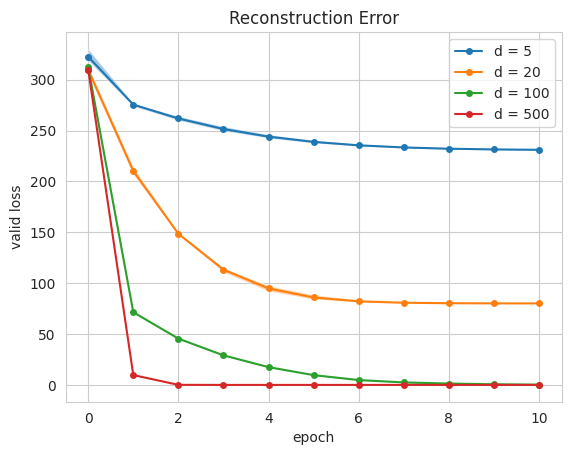

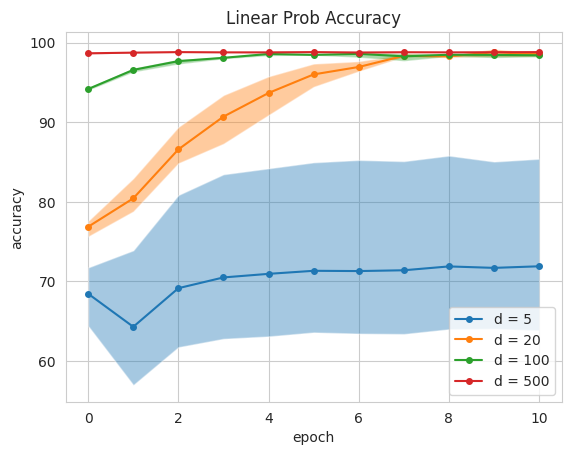

In [61]:
def plot_single(values, feats_dim):
    ############################################################################
    # TODO: Implement the following code to draw a single curve with a filled
    #       area around it.
    #
    # Hint 1: `values` is a list of three lists, where each list corresponds to
    #         one run and each entry in the list corresponds to an epoch
    # Hint 2: `feats_dim` is useful for showing legends
    ############################################################################
    x = range(0, hparams.num_epochs + 1)
    y_avg = np.mean(values, axis=0)
    y_min = np.amin(values, axis=0)
    y_max = np.amax(values, axis=0)
    plt.plot(x, y_avg, marker='o', markersize=4, label=f"d = {feats_dim}")
    plt.fill_between(x, y_min, y_max, alpha=0.4)
    ############################################################################

# Visualize valid losses
for model_idx in valid_losses.keys():
    if model_idx[0] == 'vanilla':
        plot_single(valid_losses[model_idx], model_idx[1])
################################################################################
# TODO: Implement the following code to draw legends, axis labels, and the title
################################################################################
plt.legend()
plt.xlabel("epoch")
plt.ylabel("valid loss")
plt.title("Reconstruction Error")
################################################################################
plt.show()

# Visualize valid (linear probe) accuracy
for model_idx in accuracy.keys():
    if model_idx[0] == 'vanilla':
        plot_single(accuracy[model_idx], model_idx[1])
################################################################################
# TODO: Implement the following code to draw legends, axis labels, and the title
################################################################################
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Linear Prob Accuracy")
################################################################################
plt.show()


TO_SAVE["vis_fn"] = inspect.getsource(plot_single)

#### Question

**Screenshot your visualization above** and include it in your submission of the written assignment.

#### Question

In your written assignment submission, please answer the following question: **How does changing the latent representation size of the autoencoder affect the model's performance in terms of reconstruction accuracy and linear probe accuracy? Why?** Hint: each datapoint in the synthetic dataset has 100 dimensions, with 20 high-variance dimensions that affect the class label.

## Nonlinear Dimensionality Reduction on MNIST

In the previous section, we observed that there is no advantage in terms of linear probe accuracy when we perform dimension reduction. The reason for this is that we use the entire *labeled* validation dataset to train the linear probe, rendering the use of autoencoders and self-supervised learning less useful in cases where we have ample labeled training data.

In this part, we will consider a different scenario where we have an abundance of *unlabeled* training data, but only a limited number of *labeled* examples. Specifically, we will train a non-linear autoencoder on the MNIST dataset using all images in the dataset, but only **200** labeled examples will be used to train the linear probe.

Your task is to train a non-linear autoencoder on the MNIST dataset. The objective is to achieve a few-shot linear probe accuracy of at least **79%** on the last epoch, averaged over two random runs. You may use any type of autoencoder that you have previously implemented, choose any latent representation sizes, and your grade will be evaluated on a linear scale, ranging from 0 to the maximum score.

The validation accuracy achieved on the last epoch should range from 70% to 79%. If the accuracy is less than 70%, you will receive a score of 0, and if it is greater than 79%, you will receive the full score for this autograding item.

In [ ]:
# Do not change these
NUM_REPEATS = 2
input_dims = 28 * 28
num_classes = 10
data_splits = [0.9, 0.1]


################################################################################
# TODO: Set the hyperparameters
################################################################################
hparams = argparse.Namespace(
    batch_size=100,
    num_epochs=5,
    hidden_dims=[20],
    activation="ReLU",
    lr=1e-4,
    noise_std=0.5,
    mask_prob=0.25
)
################################################################################


################################################################################
# TODO: Define a function to build the model. You are encouraged to experiment
#       with different types of autoencoders
################################################################################
def build_model():
    return Autoencoder(
        input_dims,
        hparams.hidden_dims,
        activation_cls=getattr(nn, hparams.activation)
    )
################################################################################

dataset = MNIST(hparams.batch_size, data_splits)

feats_dim = hparams.hidden_dims[-1]
train_loss, valid_loss, acc = [], [], []
for expid in range(NUM_REPEATS):
    _set_seed(expid * 227)
    model = build_model()
    experiment = Experiment(
        dataset,
        model,
        batch_size=hparams.batch_size,
        num_classes=num_classes,
        lr=hparams.lr,
        probe_train_batch=1,  # 1 batch = 200 examples
        probe_train_epochs=1000
    )
    _set_seed(1998 + expid * 227)
    train_stats = experiment.train(num_epochs=hparams.num_epochs)
    train_loss.append(train_stats["train_losses"])
    valid_loss.append(train_stats["valid_losses"])
    acc.append(train_stats["valid_accs"])

TO_SAVE["train2"] = {
    "train_loss": train_loss,
    "valid_loss": valid_loss,
    "acc": acc,
    "hparams": hparams.__dict__,
    "build_model_fn": inspect.getsource(build_model),
}

print("Avg Accuracy:", np.array(acc).mean(axis=0)[-1])